## <span style="color:green"> Numerical Simulation Laboratory: Numerical Exercises 2 </span>
### <span style="color:royalblue"> Comment on the C++ code - Usage </span>
The two C++ programs can be compiled by means of a makefile, which produces the executable **main.exe**. One could also compile and launch directly using the command **make all** or clean the existing output and .o files using **make clean**.<br>
Once the program finishes the computations, the elapsed times of each function call are shown.

## Exercise 02.1
We compute the following 1D integral via Monte Carlo 
$$ I = \int_0^1 \frac{\pi}{2}\cos(\frac {\pi}{2} x) dx = 1$$
### <span style="color:royalblue"> Comment on the C++ code - Structure </span>
The C++ code is based on the class **Stat** (stat.h), which contains the principal statistical methods (for instance, the blocking method, with progressive and block averages). In the same file one can find the class **StatIntegral**, which performs the Monte Carlo integration and relies on the class **Function**. This is the base class of many derived ones, among which the **Integrand** class. By specifying its method **Eval**, one can determine the function to be integrated.
### <span style="color:royalblue"> Comment on the Python code </span>
We define here some functions which read and plot the output data produced by the C++ program.

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

exp_value = 1 ## Integral exact value
x, av_prog, error_prog = [], [], []

def Read(filename, x, av_prog, error_prog, exp_value, skip_first_lines=0):
    x.clear()
    av_prog.clear()
    error_prog.clear()
    with open(filename) as file:
        M = file.readline().split()[1]
        N = file.readline().split()[1]
        for i in range(skip_first_lines): ## Ignore first ... values
            file.readline()
        for line in file:
            s = line.split(' ')
            x.append(int(s[0]))
            av_prog.append(float(s[1]) - exp_value)
            error_prog.append(float(s[2]))
    return M, N

def Plot(x, av_prog, error_prog, xlabel, ylabel, title, legend):
    fig, ax = plt.subplots()
    plot = ax.errorbar(x, av_prog, yerr=error_prog, color='black', ecolor='darkorange')
    ax.set_xlabel(xlabel, fontsize=13)
    ax.set_ylabel(ylabel, fontsize=14)
    ax.xaxis.grid(True)
    ax.yaxis.grid(True)
    ax.set_title(title, fontsize=15)
    plot.set_label(legend)
    ax.legend(prop={'size': 12})
    fig.set_size_inches(14.5, 5)
    return fig, ax, plot

### <span style="color:green"> 1. Sampling a uniform distribution in $[0,1]$ </span>

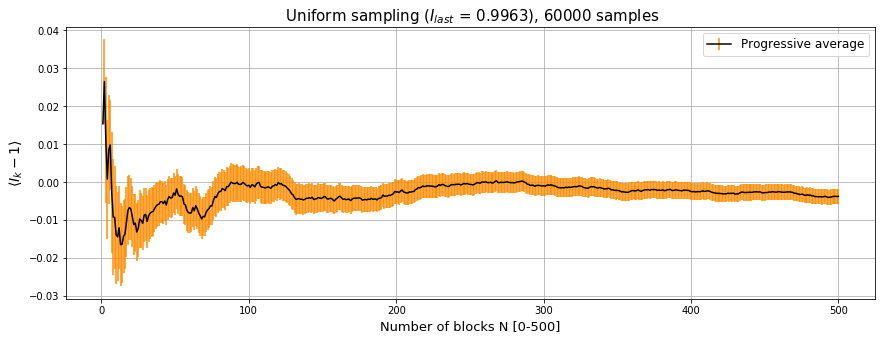

In [2]:
### Read Data ###
M, N = Read("./Esercizio02.1/prog.out", x, av_prog, error_prog, exp_value)
### Plot Data ###
fig, ax, plot = Plot(x, av_prog, error_prog, \
     f'Number of blocks N [0-{N}]', r'$\langle I_k-1 \rangle$', \
     f' Uniform sampling '+r'($I_{last}$'+f' = {exp_value+av_prog[len(av_prog)-1]:.4f}), {M} samples', \
     f'Progressive average')
plt.show()

The plot shows the behaviour of the displacement $\langle I_k-1 \rangle$ of the integral estimate from the exact value, as a function of the number of blocks of data. The number of blocks and the total sample size can be modified in the **main.cpp** file. Here we have used a uniform distribution in $[0,1]$ to sample the values of the variable $x$.

### <span style="color:green"> 2. Using importance sampling: $p(x) \propto (1-x)$ </span>

We now repeat the computation we performed in the previous section using the **importance sampling** method. In particular, we choose a distribution $p(x) = N(1-x)$, where N is the normalization factor such that
\begin{equation} I = \int_0^1 p(x) dx = 1\end{equation}
In general, for an integral on the interval $[a, b]$, the normalized version of $p(x) = mx+q$ is

\begin{equation}p(x) = \frac{mx+q}{(b-a)(m\frac{b+a}{2}+q)}\end{equation}

This is precisely the normalization adopted in the class **LineasIS** (function.h).

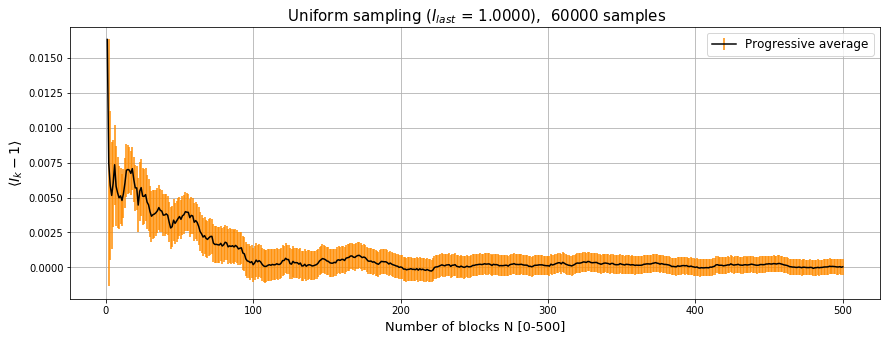

In [3]:
### Read Data ###
M, N = Read("./Esercizio02.1/prog_IS.out", x, av_prog, error_prog, exp_value)
### Plot Data ###
fig, ax, plot = Plot(x, av_prog, error_prog,
                     f'Number of blocks N [0-{N}]', r'$\langle I_k-1 \rangle$',
                     f' Uniform sampling '+r'($I_{last}$'+f" = {exp_value+av_prog[len(av_prog)-1]:.4f}), "+
                     f" {M} samples", f'Progressive average')
plt.show()

We see that for a given number N $\sim$ 60000 of samples, the importance sampling method ensures a faster and more stable convergence to the expected value than the standard integration.

## Exercise 02.2 - 3D Random Walks on cubic lattice and continuum </span>

### <span style="color:royalblue"> Comment on the C++ code - Structure </span>
The main part of the C++ code comprises the classes **Randomwalk** and **RandomwalkLattice** (randomwalk.h). In both classes the data type used is a **Vector** (vector.h), which consists of a set of points and operators in a $d$-dimensional vector space. In RandomwalkLattice we have also defined a set of generators of the lattice, which by default are set to be the unit vectors corresponding to the three cartesian axes (thus generating a cubic lattice). In Randomwalk, instead, the random motion is handled by a function which generates the two angles $\phi, \theta$ of the $3D$ spherical coordinates and then associates a translation vector (using the method **Set(radius, angles[])** of the class **Vector**).
### <span style="color:royalblue"> Comment on the Python code </span>
In this section we plot the distance $\sqrt{\langle |{\textbf{r}}_k|^2 \rangle}$ from the starting point (by default $(0, 0, 0)$, the origin of our cartesian reference frame) as a function of the random steps for the random walk in the continuum and on a cubic lattice. For each step $k$ we compute the average distance traveled $\sqrt{\langle |{\textbf{r}}_k|^2 \rangle}$ by the $N_{walks}$ different walks performed. We also show by means of a fitting that $$\sqrt{\langle |{\textbf{r}}_k|^2 \rangle}=C\sqrt{k}$$
which suggests that the random walks exhibit a diffusive behaviour.
Let us define the functions:

In [4]:
import math
from mpl_toolkits.mplot3d import Axes3D
from scipy.optimize import curve_fit

# Fitting Curve (diffusive behaviour)
def FittingCurve(x, n):
    return n*np.sqrt(x)

# Read from file
def Read(filename):
    index, mean_c, sigma_c, mean_l, sigma_l = [],[],[],[],[]
    with open(filename) as file:
        Nwalk = int(file.readline().split()[1])
        Nsteps = int(file.readline().split()[1])
        for line in file:
            index.append(int(line.split()[0]))
            mean_c.append(float(line.split()[1]))
            sigma_c.append(float(line.split()[2]))
            mean_l.append(float(line.split()[3]))
            sigma_l.append(float(line.split()[4]))
    return Nwalk, Nsteps, index, mean_c, sigma_c, mean_l, sigma_l

# Fitting
def Fit(xmin, xmax, y_array):
    x_array = np.arange(xmin, xmax+1)
    p_opt, p_cov = curve_fit(FittingCurve, x_array, y_array, bounds=([-10],[10]))
    y_fit = FittingCurve(x_array, p_opt[0])
    return p_opt[0], y_fit

def PlotRW(Nwalk, Nsteps, index, mean_c, sigma_c, mean_l, sigma_l):
    # Actual traveled distance
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))
    ax[0].errorbar(index, mean_c, yerr=sigma_c, color='black', ecolor='goldenrod', linewidth=3, elinewidth=2, 
                   label="Random walk")
    ax[0].set_xlabel("Steps", fontsize=12)
    ax[0].set_ylabel("Distance from the origin", fontsize=12)
    ax[0].set_title(f'3D Continuous Random Walk ({Nwalk} Walks, {Nsteps} Steps)')
    ax[1].errorbar(index, mean_l, yerr=sigma_l, color='black', ecolor='goldenrod', linewidth=3, elinewidth=2,
                  label="Random walk")
    ax[1].set_xlabel("Steps", fontsize=12)
    ax[1].set_ylabel("Distance from the origin", fontsize=12)
    ax[1].set_title(f'Random Walk on a 3D Cubic Lattice ({Nwalk} Walks, {Nsteps} Steps)')
    
    # Fitting curves
    xmin, xmax=index[0], index[len(index)-1]
    C, y_fit_c = Fit(xmin, xmax, mean_c)
    ax[0].plot(index, y_fit_c, color='tab:green', label=f"Fit (C={C:.4f})", linewidth=3)
    C, y_fit_l = Fit(xmin, xmax, mean_l)
    ax[1].plot(index, y_fit_l, color='tab:green', label=f"Fit (C={C:.4f})", linewidth=3)
    ax[0].legend(prop={'size':12}, loc='upper left')
    ax[1].legend(prop={'size':12}, loc='upper left')
    return 

We can now plot our results. For a suitable choice of parameters ($N_{walks}, N_{steps}$ for each random walk) the fitting curve (represented in green) will overlap nearly exactly to the actual traveled distance.

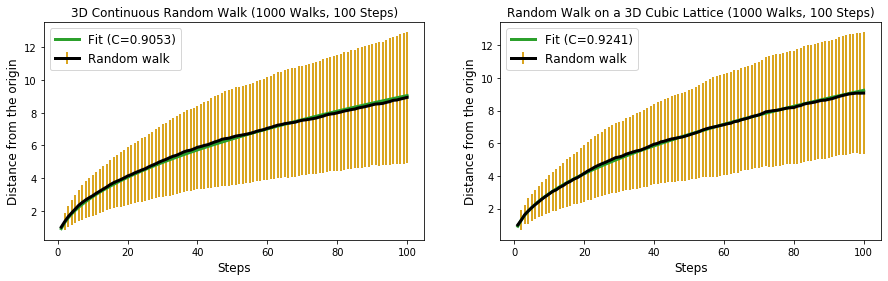

In [5]:
Nwalk, Nsteps, index, mean_c, sigma_c, mean_l, sigma_l = Read("./Esercizio02.2/walk.out")
PlotRW(Nwalk, Nsteps, index, mean_c, sigma_c, mean_l, sigma_l)

plt.show()

We have also decided to plot four different $3D$ random walks for each configuration (continuum, cubic lattice). The starting point is always the origin $(0, 0, 0)$ and is represented by a black dot.

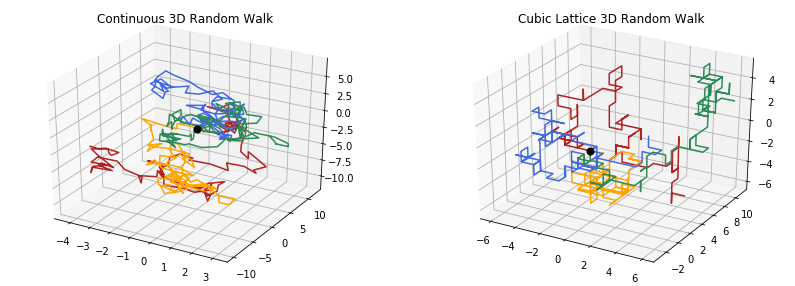

In [6]:
## Read <Nwalks> Random walks to be plotted
with open("./Esercizio02.2/continuous.xyz") as file:
    Nwalks = int(file.readline().split()[1])
    Nsteps = int(file.readline().split()[1])
    c= [[[] for i in range(0, 3)] for i in range(0, Nwalks)]
    
    for i in range(0, Nwalks):
        for j in range(0, Nsteps):
            x = file.readline().split()
            for k in range(0, 3):
                c[i][k].append(float(x[k]))
        file.readline()
with open("./Esercizio02.2/lattice.xyz") as file:
    Nwalks = int(file.readline().split()[1])
    Nsteps = int(file.readline().split()[1])
    l = [[[] for i in range(0, 3)] for i in range(0, Nwalks)]
    
    for i in range(0, Nwalks):
        for j in range(0, Nsteps):
            x = file.readline().split()
            for k in range(0, 3):
                l[i][k].append(float(x[k]))
        file.readline()                

col=['firebrick', 'orange', 'royalblue', 'seagreen']
f = plt.figure(figsize=(14, 5))
ax = [f.add_subplot(1, 2, i, projection='3d') for i in range(1,3)]
for n in range(0, Nwalks):
    ax[0].plot(c[n][0], c[n][1], c[n][2], color=col[n])
    ax[1].plot(l[n][0], l[n][1], l[n][2], color=col[n])
ax[0].scatter(0, 0, 0, s=50, color='black')
ax[1].scatter(0, 0, 0, s=50, color='black')
ax[0].set_title("Continuous 3D Random Walk")
ax[1].set_title("Cubic Lattice 3D Random Walk")
plt.show()